In [2]:

import paddle
import paddle.fluid as fluid
import numpy
import math
import sys
from __future__ import print_function

In [3]:
BATCH_SIZE = 20

train_reader = paddle.batch(
    paddle.reader.shuffle(
        paddle.dataset.uci_housing.train(), buf_size=500),
        batch_size=BATCH_SIZE)

test_reader = paddle.batch(
    paddle.reader.shuffle(
        paddle.dataset.uci_housing.test(), buf_size=500),
        batch_size=BATCH_SIZE)

In [4]:
x = fluid.layers.data(name='x', shape=[13], dtype='float32') # 定义输入的形状和数据类型
y = fluid.layers.data(name='y', shape=[1], dtype='float32') # 定义输出的形状和数据类型
y_predict = fluid.layers.fc(input=x, size=1, act=None) # 连接输入和输出的全连接层

main_program = fluid.default_main_program() # 获取默认/全局主函数
startup_program = fluid.default_startup_program() # 获取默认/全局启动程序

cost = fluid.layers.square_error_cost(input=y_predict, label=y) # 利用标签数据和输出的预测数据估计方差
avg_loss = fluid.layers.mean(cost) # 对方差求均值，得到平均损失

In [5]:
sgd_optimizer = fluid.optimizer.SGD(learning_rate=0.001)
sgd_optimizer.minimize(avg_loss)

#克隆main_program得到test_program
#有些operator在训练和测试之间的操作是不同的，例如batch_norm，使用参数for_test来区分该程序是用来训练还是用来测试
#该api不会删除任何操作符,请在backward和optimization之前使用
test_program = main_program.clone(for_test=True)

In [6]:
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace() # 指明executor的执行场所

###executor可以接受传入的program，并根据feed map(输入映射表)和fetch list(结果获取表)向program中添加数据输入算子和结果获取算子。使用close()关闭该executor，调用run(...)执行program。
exe = fluid.Executor(place)


In [14]:
num_epochs = 100

def train_test(executor, program, reader, feeder, fetch_list):
    accumulated = 1 * [0]
    count = 0
    for data_test in reader():
        outs = executor.run(program=program,
                            feed=feeder.feed(data_test),
                            fetch_list=fetch_list)
        accumulated = [x_c[0] + x_c[1][0] for x_c in zip(accumulated, outs)] # 累加测试过程中的损失值
        count += 1 # 累加测试集中的样本数量
    return [x_d / count for x_d in accumulated] # 计算平均损失

In [15]:
%matplotlib inline
params_dirname = "fit_a_line.inference.model"
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])
exe.run(startup_program)
train_prompt = "train cost"
test_prompt = "test cost"
from paddle.utils.plot import Ploter
plot_prompt = Ploter(train_prompt, test_prompt)
step = 0

exe_test = fluid.Executor(place)

In [16]:
for pass_id in range(num_epochs):
    for data_train in train_reader():
        avg_loss_value, = exe.run(main_program,
                                  feed=feeder.feed(data_train),
                                  fetch_list=[avg_loss])
        if step % 10 == 0: # 每10个批次记录并输出一下训练损失
            plot_prompt.append(train_prompt, step, avg_loss_value[0])
            plot_prompt.plot()
            print("%s, Step %d, Cost %f" %
	                  (train_prompt, step, avg_loss_value[0]))
        if step % 100 == 0:  # 每100批次记录并输出一下测试损失
            test_metics = train_test(executor=exe_test,
                                     program=test_program,
                                     reader=test_reader,
                                     fetch_list=[avg_loss.name],
                                     feeder=feeder)
            plot_prompt.append(test_prompt, step, test_metics[0])
            plot_prompt.plot()
            print("%s, Step %d, Cost %f" %
	                  (test_prompt, step, test_metics[0]))
            if test_metics[0] < 10.0: # 如果准确率达到要求，则停止训练
                break

        step += 1

        if math.isnan(float(avg_loss_value[0])):
            sys.exit("got NaN loss, training failed.")

        #保存训练参数到之前给定的路径中
        if params_dirname is not None:
            fluid.io.save_inference_model(params_dirname, ['x'], [y_predict], exe)

NameError: name 'basestring' is not defined

预测
需要构建一个使用训练好的参数来进行预测的程序，训练好的参数位置在params_dirname。

准备预测环境
类似于训练过程，预测器需要一个预测程序来做预测。我们可以稍加修改我们的训练程序来把预测值包含进来。

In [10]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

预测
保存图片

In [11]:
def save_result(points1, points2):
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    x1 = [idx for idx in range(len(points1))]
    y1 = points1
    y2 = points2
    l1 = plt.plot(x1, y1, 'r--', label='predictions')
    l2 = plt.plot(x1, y2, 'g--', label='GT')
    plt.plot(x1, y1, 'ro-', x1, y2, 'g+-')
    plt.title('predictions VS GT')
    plt.legend()
    plt.savefig('./image/prediction_gt.png')

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

In [12]:
with fluid.scope_guard(inference_scope):
    [inference_program, feed_target_names,
     fetch_targets] = fluid.io.load_inference_model(params_dirname, infer_exe) # 载入预训练模型
    batch_size = 10

    infer_reader = paddle.batch(
        paddle.dataset.uci_housing.test(), batch_size=batch_size) # 准备测试集

    infer_data = next(infer_reader())
    infer_feat = numpy.array(
        [data[0] for data in infer_data]).astype("float32") # 提取测试集中的数据
    infer_label = numpy.array(
        [data[1] for data in infer_data]).astype("float32") # 提取测试集中的标签

    assert feed_target_names[0] == 'x'
    results = infer_exe.run(inference_program,
                            feed={feed_target_names[0]: numpy.array(infer_feat)},
                            fetch_list=fetch_targets) # 进行预测
    #打印预测结果和标签并可视化结果
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val)) # 打印预测结果

    print("\nground truth:")
    for idx, val in enumerate(infer_label):
        print("%d: %.2f" % (idx, val)) # 打印标签值

    save_result(results[0], infer_label) # 保存图片

ValueError: ("There is no directory named '%s'", 'fit_a_line.inference.model')

Train cost, Step 0, Cost 711.901367
Test cost, Step 0, Cost 287.930410
Train cost, Step 10, Cost 610.796631
Train cost, Step 20, Cost 307.411530
Train cost, Step 30, Cost 710.259094
Train cost, Step 40, Cost 783.403503
Train cost, Step 50, Cost 642.073364
Train cost, Step 60, Cost 372.627319
Train cost, Step 70, Cost 349.106995
Train cost, Step 80, Cost 559.939148
Train cost, Step 90, Cost 255.194977
Train cost, Step 100, Cost 479.838715
Test cost, Step 100, Cost 176.171171
Train cost, Step 110, Cost 364.533539
Train cost, Step 120, Cost 562.566040
Train cost, Step 130, Cost 379.290100
Train cost, Step 140, Cost 345.407806
Train cost, Step 150, Cost 275.902374
Train cost, Step 160, Cost 422.054596
Train cost, Step 170, Cost 341.821075
Train cost, Step 180, Cost 319.663666
Train cost, Step 190, Cost 233.978226
Train cost, Step 200, Cost 167.847855
Test cost, Step 200, Cost 130.771984
Train cost, Step 210, Cost 244.766525
Train cost, Step 220, Cost 206.689285
Train cost, Step 230, Cost 4

Train cost, Step 2000, Cost 24.493427
Test cost, Step 2000, Cost 16.358697
Train cost, Step 2010, Cost 32.358803
Train cost, Step 2020, Cost 47.178688
Train cost, Step 2030, Cost 47.942436
Train cost, Step 2040, Cost 74.985970
Train cost, Step 2050, Cost 30.416565
Train cost, Step 2060, Cost 21.178795
Train cost, Step 2070, Cost 42.036270
Train cost, Step 2080, Cost 104.555275
Train cost, Step 2090, Cost 44.326031
infer results: (House Price)
0: 14.52
1: 14.89
2: 14.50
3: 16.71
4: 15.02
5: 15.92
6: 15.59
7: 15.07
8: 12.17
9: 14.97

ground truth:
0: 8.50
1: 5.00
2: 11.90
3: 27.90
4: 17.20
5: 27.50
6: 15.00
7: 17.20
8: 17.90
9: 16.30



/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:38: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/apple/anaconda/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/apple/anaconda/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/apple/anaconda/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 499, in start
    s

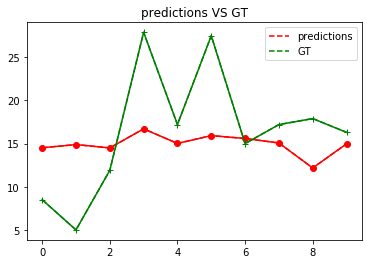

In [17]:
#   Copyright (c) 2018 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from __future__ import print_function

import paddle
import paddle.fluid as fluid
import numpy
import math
import sys


# For training test cost
def train_test(executor, program, reader, feeder, fetch_list):
    accumulated = 1 * [0]
    count = 0
    for data_test in reader():
        outs = executor.run(
            program=program, feed=feeder.feed(data_test), fetch_list=fetch_list)
        accumulated = [x_c[0] + x_c[1][0] for x_c in zip(accumulated, outs)]
        count += 1
    return [x_d / count for x_d in accumulated]


def save_result(points1, points2):
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    x1 = [idx for idx in range(len(points1))]
    y1 = points1
    y2 = points2
    l1 = plt.plot(x1, y1, 'r--', label='predictions')
    l2 = plt.plot(x1, y2, 'g--', label='GT')
    plt.plot(x1, y1, 'ro-', x1, y2, 'g+-')
    plt.title('predictions VS GT')
    plt.legend()
    plt.savefig('./image/prediction_gt.png')


def main():
    batch_size = 20
    train_reader = paddle.batch(
        paddle.reader.shuffle(paddle.dataset.uci_housing.train(), buf_size=500),
        batch_size=batch_size)
    test_reader = paddle.batch(
        paddle.reader.shuffle(paddle.dataset.uci_housing.test(), buf_size=500),
        batch_size=batch_size)

    # feature vector of length 13
    x = fluid.layers.data(name='x', shape=[13], dtype='float32')
    y = fluid.layers.data(name='y', shape=[1], dtype='float32')
    y_predict = fluid.layers.fc(input=x, size=1, act=None)

    main_program = fluid.default_main_program()
    startup_program = fluid.default_startup_program()

    cost = fluid.layers.square_error_cost(input=y_predict, label=y)
    avg_loss = fluid.layers.mean(cost)

    sgd_optimizer = fluid.optimizer.SGD(learning_rate=0.001)
    sgd_optimizer.minimize(avg_loss)

    test_program = main_program.clone(for_test=True)

    # can use CPU or GPU
    use_cuda = False
    place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
    exe = fluid.Executor(place)

    # Specify the directory to save the parameters
    params_dirname = "fit_a_line.inference.model"
    num_epochs = 100

    # main train loop.
    feeder = fluid.DataFeeder(place=place, feed_list=[x, y])
    exe.run(startup_program)

    train_prompt = "Train cost"
    test_prompt = "Test cost"
    step = 0

    exe_test = fluid.Executor(place)

    for pass_id in range(num_epochs):
        for data_train in train_reader():
            avg_loss_value, = exe.run(
                main_program,
                feed=feeder.feed(data_train),
                fetch_list=[avg_loss])
            if step % 10 == 0:  # record a train cost every 10 batches
                print("%s, Step %d, Cost %f" %
                      (train_prompt, step, avg_loss_value[0]))

            if step % 100 == 0:  # record a test cost every 100 batches
                test_metics = train_test(
                    executor=exe_test,
                    program=test_program,
                    reader=test_reader,
                    fetch_list=[avg_loss],
                    feeder=feeder)
                print("%s, Step %d, Cost %f" %
                      (test_prompt, step, test_metics[0]))
                # If the accuracy is good enough, we can stop the training.
                if test_metics[0] < 10.0:
                    break

            step += 1

            if math.isnan(float(avg_loss_value[0])):
                sys.exit("got NaN loss, training failed.")
        if params_dirname is not None:
            # We can save the trained parameters for the inferences later
            fluid.io.save_inference_model(params_dirname, ['x'], [y_predict],
                                          exe)

    infer_exe = fluid.Executor(place)
    inference_scope = fluid.core.Scope()

    # infer
    with fluid.scope_guard(inference_scope):
        [inference_program, feed_target_names, fetch_targets
         ] = fluid.io.load_inference_model(params_dirname, infer_exe)
        batch_size = 10

        infer_reader = paddle.batch(
            paddle.dataset.uci_housing.test(), batch_size=batch_size)

        infer_data = next(infer_reader())
        infer_feat = numpy.array(
            [data[0] for data in infer_data]).astype("float32")
        infer_label = numpy.array(
            [data[1] for data in infer_data]).astype("float32")

        assert feed_target_names[0] == 'x'
        results = infer_exe.run(
            inference_program,
            feed={feed_target_names[0]: numpy.array(infer_feat)},
            fetch_list=fetch_targets)

        print("infer results: (House Price)")
        for idx, val in enumerate(results[0]):
            print("%d: %.2f" % (idx, val))

        print("\nground truth:")
        for idx, val in enumerate(infer_label):
            print("%d: %.2f" % (idx, val))

        save_result(results[0], infer_label)


if __name__ == '__main__':
    main()